## Final Project: Stock Modeling 

This notebook models stock data that has been pre-processed with news sentiment data, then predicts the Closing, High, and Low values for the current buisness day and following business day. Below is the process for preparing the data then modeling the data for the best predictions.

## Section 1: Preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from datetime import datetime, timedelta

# Set Console formatting for panda prints
# pd.set_option('display.height', 1000)
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.width', 1000)
# pd.options.mode.chained_assignment = None

# **********************************************************************************************************************
# Modeling / Prepare Data
data = pd.read_csv('https://raw.githubusercontent.com/mwilchek/Stock-Modeling/master/DJ_NEWS_SENTIMENT_DATA.csv')
data['Cycle_Change'] = data.Max_Sentiment.eq(data.Max_Sentiment.shift())
dummies = pd.get_dummies(data.Cycle_Change)
data = data.join(dummies)
data_tomorrow = pd.read_csv('https://raw.githubusercontent.com/mwilchek/Stock-Modeling/master/DJ_NEWS_SENTIMENT_DATA.csv')

# Move certain columns up by one row for data_tomorrow
data_tomorrow.Anger = data_tomorrow.Anger.shift(+1)
data_tomorrow.Anticipation = data_tomorrow.Anticipation.shift(+1)
data_tomorrow.Disgust = data_tomorrow.Disgust.shift(+1)
data_tomorrow.Fear = data_tomorrow.Fear.shift(+1)
data_tomorrow.Joy = data_tomorrow.Joy.shift(+1)
data_tomorrow.Sadness = data_tomorrow.Sadness.shift(+1)
data_tomorrow.Surprise = data_tomorrow.Surprise.shift(+1)
data_tomorrow.Trust = data_tomorrow.Trust.shift(+1)
data_tomorrow.Negative = data_tomorrow.Negative.shift(+1)
data_tomorrow.Positive = data_tomorrow.Positive.shift(+1)
data_tomorrow.Max_Sentiment = data_tomorrow.Max_Sentiment.shift(+1)
data_tomorrow.Sentiment_Proportion = data_tomorrow.Sentiment_Proportion.shift(+1)

# Delete the first row of data_tomorrow
data_tomorrow.drop(data_tomorrow.head(1).index, inplace=True)

train_data = data[:-1]  # train data
today_record = data.tail(1)  # test data (validate current day and predict from following day)

# Get train data's most recent date of data
train_date_to = today_record['Date'].values
train_date_to = datetime.strptime(train_date_to[0], '%m/%d/%Y') - timedelta(days=1)
train_date_to = train_date_to.strftime("%m/%d/%Y")

train_data_tomorrow = data_tomorrow[:-1]  # train data
# NOTE: Should train_data_tomorrow include data from today? Does it?
tomorrow_record = data_tomorrow.tail(1)  # test data (validate current day and predict from following day)
# NOTE: Check if tomorrow_record should be blank because your shifting values above
data.tail(n=5)

,Date,Open,High,Low,Close,Volume,Adj.Close,change,Anger,Anticipation,...,Sadness,Surprise,Trust,Negative,Positive,Max_Sentiment,Sentiment_Proportion,Cycle_Change,False,True
2011,11/13/2018,25321.210938,25511.029297,25193.779297,25286.490234,339690000,25286.490234,-0.138225,368,333,...,314,247,417,734,609,Negative,0.186436,True,0,1
2012,11/14/2018,25388.080078,25501.289063,24935.820313,25080.500000,384243467,25080.500000,-1.213172,366,390,...,260,268,462,682,646,Negative,0.173625,True,0,1
2013,11/15/2018,25061.480469,25354.560547,24787.789063,25289.269531,392754253,25289.269531,0.909780,380,345,...,287,248,417,649,562,Negative,0.174135,True,0,1
2014,11/16/2018,25242.349609,25510.230469,25147.800781,25413.220703,354461249,25413.220703,0.677442,64,59,...,65,25,72,117,101,Negative,0.176471,True,0,1
2015,11/19/2018,25392.609375,25392.609375,24900.980469,25017.439453,358093278,25017.439453,-1.476843,588,444,...,504,318,558,992,752,Negative,0.180626,True,0,1


Adding Local Functions for Accuracy Printing

In [2]:
########################################################################################################################
# Local method to get Margin of Error
def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return (abs(current - previous) / previous) * 100.0
    except ZeroDivisionError:
        return 0

Section 2: Data Modeling Exploration

In this section we created a pipeline of Regressor type models with a number of parameters that we tune to hopefully find an accurate model for predicting the closing value. We hope that with good results, we can mimic the process for predicting the High and Low values for the current and next business day.

In [3]:
########################################################################################################################
# MODELING EXPLORATION #################################################################################################
# Testing best model for f(x) = Close ~ Features
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Get Feature values
x = data[['Open', 'High', 'Low', False, True]].values

# Get Target values
y = data['Close'].values

regression_models = {'lr': LinearRegression(n_jobs=-1),
                     'mlp': MLPRegressor(random_state=0),
                     'dt': DecisionTreeRegressor(random_state=0),
                     'rf': RandomForestRegressor(random_state=0, n_jobs=-1),
                     'svr': SVR(max_iter=-1)}

pipe_regrs = {}

# Create list of pipeline models to test with that standardize the data
for name, regression_models in regression_models.items():
    pipe_regrs[name] = Pipeline([('StandardScaler', StandardScaler()), ('regr', regression_models)])

param_grids = {}

# Linear Regression Parameter Options:
param_grid = [{'regr__normalize': ["True"]},
              {'regr__normalize': ["False"]}]

# Add Linear Regression Parameters to dictionary grid
param_grids['lr'] = param_grid

# MLP Parameter Options:
alpha_range = [10 ** i for i in range(-4, 5)]

param_grid = [{'regr__hidden_layer_sizes': [10, 100, 200]}]

# Add Multi-layer Perceptron Parameters to dictionary grid
param_grids['mlp'] = param_grid

# Decision Tree Regression Parameter Options:
param_grid = [{'regr__criterion': ['mse', 'mae'],
               'regr__min_samples_split': [2, 6, 10],
               'regr__min_samples_leaf': [1, 6, 10],
               'regr__max_features': ['auto', 'sqrt', 'log2']}]

# Add Decision Tree Parameters to dictionary grid
param_grids['dt'] = param_grid

# Random Forest Regression Parameter Options:
param_grid = [{'regr__n_estimators': [10, 100],
               'regr__criterion': ['mse', 'mae'],
               'regr__min_samples_split': [2, 6, 10],
               'regr__min_samples_leaf': [1, 6, 10],
               'regr__max_features': ['auto', 'sqrt', 'log2']}]

# Add Random Forest Parameters to dictionary grid
param_grids['rf'] = param_grid

# Support Vector Machine (SVM) Parameter Options:
param_grid = [{'regr__C': [0.1, 1, 10],
               'regr__gamma': [0.1, 1, 10],
               'regr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

# Add SVM Parameters to dictionary grid
param_grids['svr'] = param_grid

# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# Scoring Param: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# For each regression
for name in pipe_regrs.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipe_regrs[name],
                      param_grid=param_grids[name],
                      scoring='neg_mean_squared_error',
                      n_jobs=1,
                      cv=None)
    print("Modeling: " + str(pipe_regrs[name]))
    # Fit the pipeline
    gs = gs.fit(x, y)

    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    print("Modeling Completed - Appending scores...")

Modeling: Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False))])
Modeling Completed - Appending scores...
Modeling: Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       lear...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])
Modeling Completed - Appending scores...
Modeling: Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,


Depending on the user's computer, the amount of time to complete the Pipeline can be between 5-10mins.

In [4]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x: x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1],
           type(best_score_param_estimator[2].named_steps['regr'])], end='\n\n')

[-2953.3858226604034, {'regr__normalize': 'True'}, <class 'sklearn.linear_model.base.LinearRegression'>]

[-8413.8066836657472, {'regr__C': 10, 'regr__gamma': 0.1, 'regr__kernel': 'linear'}, <class 'sklearn.svm.classes.SVR'>]

[-2389698.7321564984, {'regr__criterion': 'mse', 'regr__max_features': 'sqrt', 'regr__min_samples_leaf': 1, 'regr__min_samples_split': 6}, <class 'sklearn.tree.tree.DecisionTreeRegressor'>]

[-2418838.6060986766, {'regr__criterion': 'mae', 'regr__max_features': 'auto', 'regr__min_samples_leaf': 1, 'regr__min_samples_split': 2, 'regr__n_estimators': 10}, <class 'sklearn.ensemble.forest.RandomForestRegressor'>]

[-137551839.65989861, {'regr__hidden_layer_sizes': 200}, <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>]



It appears that the '{'regr__normalize': 'True'}, <class 'sklearn.linear_model.base.LinearRegression'>]' model from the Pipeline was the best scored. Let us practice predicting the cclosing value of the stock with a Linear Regression model with the best tuned parameters from our GridSearchCV. 

In [5]:
# Declare best model from GridSearchCV where normalize set to True is the default parameter
lr = LinearRegression(n_jobs=-1)

# Fit the model with our data
lr = lr.fit(x, y)

# Predict on Today Close
today_close = today_record[['Open', 'High', 'Low', False, True]].values
y_pred = lr.predict(today_close)

# Print Results
print("Actual Closing Value: " + str(today_record['Close'].values[0]))
print("Predicted Closing Value: " + str(y_pred[0]))

error = get_change(y_pred[0], today_record['Close'].values[0])
print("Accuracy error for prediction: " + str(round(error, 4)) + "%")

Actual Closing Value: 25017.439453
Predicted Closing Value: 25011.9371854
Accuracy error for prediction: 0.022%


In [6]:
#SVR case
# Declare best model from GridSearchCV where normalize set to True is the default parameter
sv = SVR()

# Fit the model with our data
sv = sv.fit(x, y)

# Predict on Today Close
today_close = today_record[['Open', 'High', 'Low', False, True]].values
y_pred = sv.predict(today_close)

# Print Results
print("Actual Closing Value: " + str(today_record['Close'].values[0]))
print("Predicted Closing Value: " + str(y_pred[0]))

error = get_change(y_pred[0], today_record['Close'].values[0])
print("Accuracy error for prediction: " + str(round(error, 4)) + "%")

Actual Closing Value: 25017.439453
Predicted Closing Value: 13077.5
Accuracy error for prediction: 47.7265%


Using sklearn our prediction results were pretty close to the actual, ecspecially with our Linear Regression model. However, it might be possible that the model could be overfit with such a high accuracy. Based on additional academic research for modeling stock data we also want to explore OLS regression to see if there is any noticeable change in predictions.

In [7]:
# OLS Regression Test on 'Close'
import statsmodels.formula.api as smf

# Define formula string for Stats-model API
formula = 'Close ~ Open + High + Low + Cycle_Change'

# Define Training Data
dta = train_data[['Close', 'Open', 'High', 'Low', 'Anger', 'Anticipation',
                  'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                  'Trust', 'Negative', 'Positive', 'Cycle_Change', 'Sentiment_Proportion']].copy()

# Set the Model
ols_today_close_model = smf.ols(formula=formula, data=dta).fit()

# Print results
print(ols_today_close_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.949e+06
Date:                Mon, 26 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:23:57   Log-Likelihood:                -10906.
No. Observations:                2015   AIC:                         2.182e+04
Df Residuals:                    2010   BIC:                         2.185e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0419 

As we can see the model is clearly overfit based on the Adj. R Squared equaling to 1. In order to prevent overfitting, we will revise our model with a regularized fit.

In [8]:
# Update Model with Regularized Fit to prevent over-fitting; alpha and weight values were set.
olsUpdate_today_close = smf.ols(formula=formula, data=dta).fit_regularized(alpha=10, L1_wt=.6)

Now we practice predicting on today's record with the revised model.

In [9]:
# Actual Data for today:
today_record.head()

,Date,Open,High,Low,Close,Volume,Adj.Close,change,Anger,Anticipation,...,Sadness,Surprise,Trust,Negative,Positive,Max_Sentiment,Sentiment_Proportion,Cycle_Change,False,True
2015,11/19/2018,25392.609375,25392.609375,24900.980469,25017.439453,358093278,25017.439453,-1.476843,588,444,...,504,318,558,992,752,Negative,0.180626,True,0,1


Predicting Close value on today's stock using train data up to 11/18/2018: 
Actual Closing Value for: 25017.439453
Predicted Closing Value: 25399.318


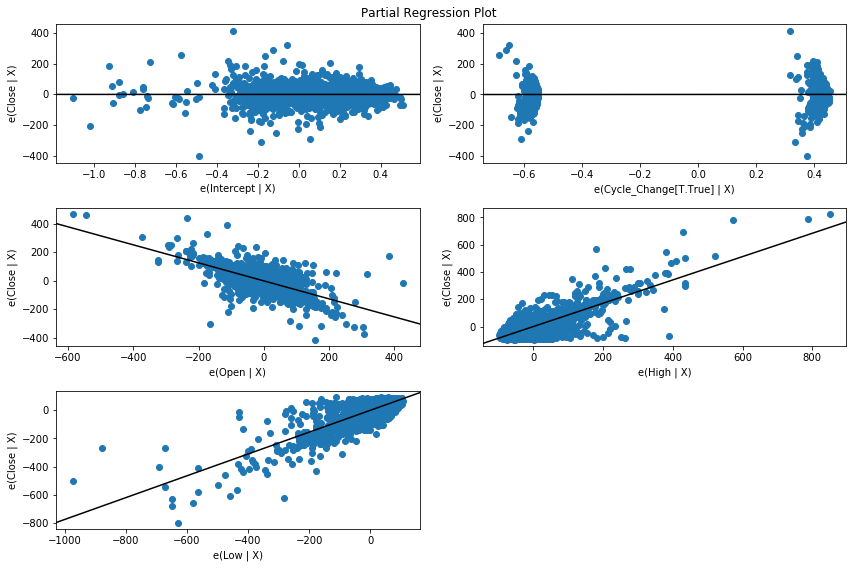

In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

print("Predicting Close value on today's stock using train data up to " + str(train_date_to) + ": ")

olsUpdate_today_close_prediction = olsUpdate_today_close.predict(today_record)

print("Actual Closing Value for: " + str(today_record['Close'].values[0]))
print("Predicted Closing Value: " + str(round(olsUpdate_today_close_prediction.values[0], 3)))

# Show Updated Model
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(ols_today_close_model, fig=fig)
# Added try/except to avoid possible duplicate plot issue with graph output
try:
    fig[0]
except TypeError:
    fig

It would appear an OLS Regularized fit regression model fairly quite accurate as well to the actual value based on the above plots. We are only a few points off from the actual. The DJI has had some large variability lately, so this model may be taking into consideration this more. If we can hyperpameter tune the sentiment values in our formula, and the alpha and weight values for the regularized parameters we may be able to create a stronger model for predicting stock values with news sentiment data as a significant relationship.

## Section 3: Hyperparameter Tuning for OLS Regularized Regression

In this section we will create custom local methods that will find the most significant sentiment for today's stock values in Close, High, and Low using a RandForestRegressor model.

In [11]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

########################################################################################################
# TODAY: Local method to identify most significant feature in dataset compared to y
def identify_sig_feature_4_today(y_variable, graph_data):
    
    warnings.filterwarnings("ignore")
    
    # Split Data Into X, which are ALL the features
    x = data.iloc[:, 9:18].values

    # Split Data Into y, which are the associated targets/classifications; looking at Volume
    y = data[np.unicode(y_variable)].values

    # Get the Column Names for Sentiment, Ignore Index
    feat_labels = data.columns[9:19]

    # Randomly choose 20% of the data for testing; want a large train set (set random_state as 0)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    # Declare the StandardScaler
    std_scaler = StandardScaler()

    # Standardize the features in the training data
    X_train = std_scaler.fit_transform(X_train)

    # Standardize the features in testing data
    X_test = std_scaler.transform(X_test)

    # Start The Random Forest Regressor
    treereg = RandomForestRegressor(n_estimators=100, max_depth=11, random_state=0)

    # Execute The Data With The Random Forest Regressor
    treereg.fit(X_train, y_train)

    print('The ' + str(y_variable) + ' accuracy of the random forest for today sentiment is: ' + str(treereg.score(X_test, y_test)))

    # Get The Important Features From The Regressor
    importances = treereg.feature_importances_

    # Sort The Features By The Most Important
    indices = np.argsort(importances)[::-1]

    # Return data
    df_cols = ['Sentiment', 'Importance']
    master_df = pd.DataFrame(columns=df_cols)

    for f in range(x.shape[1]):
        sentiment = feat_labels[f]
        importance = importances[indices[f]]
        temp_data = {'Sentiment': sentiment,
                     'Importance': importance}
        master_df = master_df.append(temp_data, ignore_index=True)

    highest_sentiment = master_df['Sentiment'].iloc[0]
    highest_importance = master_df['Importance'].iloc[0]

    if graph_data == "TRUE":
        # Output Data As A Plot for Overall Data set
        plt.title('Today Feature Importances ' + np.unicode(y_variable))
        plt.bar(range(x.shape[1]), importances[indices], color='lightblue', align='center')
        plt.xticks(range(x.shape[1]), feat_labels, rotation=90)
        plt.xlim([-1, x.shape[1]])
        plt.tight_layout()
        plt.show()

    return highest_sentiment, highest_importance


########################################################################################################
# TOMORROW: Local method to identify most significant feature in dataset compared to y
def identify_sig_feature_4_tomorrow(y_variable, graph_data):
    
    warnings.filterwarnings("ignore")
    
    # Split Data Into X, which are ALL the features
    x = data_tomorrow.iloc[:, 9:18].values

    # Split Data Into y, which are the associated targets/classifications; looking at Volume
    y = data_tomorrow[np.unicode(y_variable)].values

    # Get the Column Names for Sentiment, Ignore Index
    feat_labels = data_tomorrow.columns[9:19]

    # Randomly choose 20% of the data for testing; want a large train set (set random_state as 1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # Declare the StandardScaler
    std_scaler = StandardScaler()

    # Standardize the features in the training data
    X_train = std_scaler.fit_transform(X_train)

    # Standardize the features in testing data
    X_test = std_scaler.transform(X_test)

    # Start The Random Forest Regressor
    treereg = RandomForestRegressor(n_estimators=100, max_depth=11, random_state=1)

    # Execute The Data With The Random Forest Regressor
    treereg.fit(X_train, y_train)

    print('The ' + str(y_variable) + ' accuracy of the random forest for tomorrow sentiment is: ' + str(treereg.score(X_test, y_test)))

    # Get The Important Features From The Regressor
    importances = treereg.feature_importances_

    # Sort The Features By The Most Important
    indices = np.argsort(importances)[::-1]

    # Return data
    df_cols = ['Sentiment', 'Importance']
    master_df = pd.DataFrame(columns=df_cols)

    for f in range(x.shape[1]):
        sentiment = feat_labels[f]
        importance = importances[indices[f]]
        temp_data = {'Sentiment': sentiment,
                     'Importance': importance}
        master_df = master_df.append(temp_data, ignore_index=True)

    highest_sentiment = master_df['Sentiment'].iloc[0]
    highest_importance = master_df['Importance'].iloc[0]

    if graph_data == "TRUE":
        # Output Data As A Plot for Overall Data set
        plt.title('Tomorrow Feature Importances ' + np.unicode(y_variable))
        plt.bar(range(x.shape[1]), importances[indices], color='lightblue', align='center')
        plt.xticks(range(x.shape[1]), feat_labels, rotation=90)
        plt.xlim([-1, x.shape[1]])
        plt.tight_layout()
        plt.show()

    return highest_sentiment, highest_importance


########################################################################################################
# Local method to correctly retrieve appropriate paramters for Regularized Fit Regression based on Ridge Regression
def get_fit_regression_params(significant_sentiment, target_variable, sentiment_value):
    
    warnings.filterwarnings("ignore")
    
    # Define the data needed for this section, and as defined by highest_sentiment
    x = data[significant_sentiment].values.reshape(-1, 1)

    y = data[np.unicode(target_variable)].values  # used to be just data.High

    # Standardize features
    scaler = StandardScaler()
    x_std = scaler.fit_transform(x)
    
    # Create ridge regression with alpha values from .1 to 10.0, in increments of 0.1
    regr_cv = RidgeCV(alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                              1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,
                              2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0,
                              3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.0,
                              4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0,
                              5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0,
                              6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0,
                              7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0,
                              8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0,
                              9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0])

    # Place x and y variables in the proper format for model_cv.
    y = np.array(y)
    x_std = x_std.reshape((len(y), 1))
    y = y.reshape((len(y), 1))

    # Determine the best alpha value to use.
    model_cv = regr_cv.fit(x_std, y)
    alpha_val_today = model_cv.alpha_

    # Set the L1 value based on significant_sentiment_value
    if sentiment_value >= 0.7:
        weight_value = 0.4
    elif sentiment_value >= 0.4:
        weight_value = 0.5
    else:
        weight_value = 0.6

    return alpha_val_today, weight_value



Now that we have the local functions to tune the parameters for our prediction formula and regularized fit parameters, let's practice again on the Today's closing value.

## Section 4: OLS Regression Modeling

The Close accuracy of the random forest for today sentiment is: 0.196191176538
The High accuracy of the random forest for today sentiment is: 0.198278159804
The Low accuracy of the random forest for today sentiment is: 0.194930562903


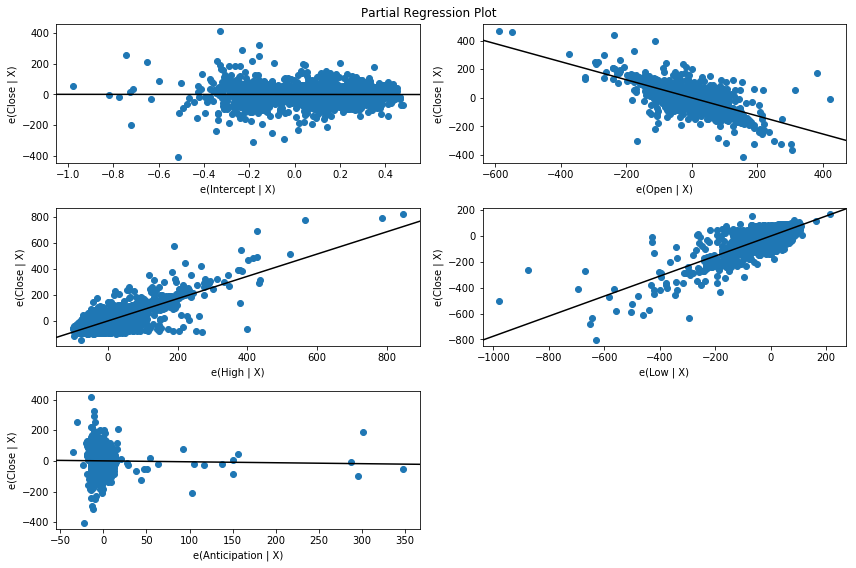

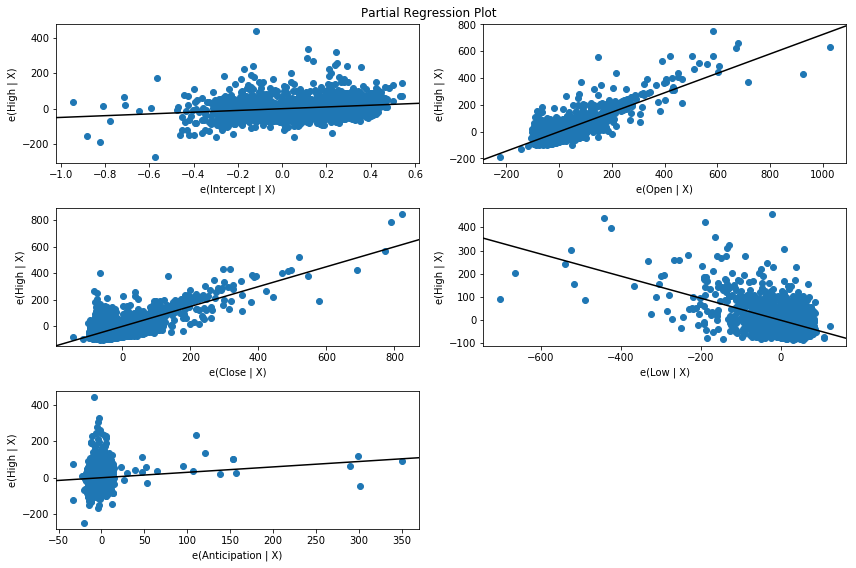

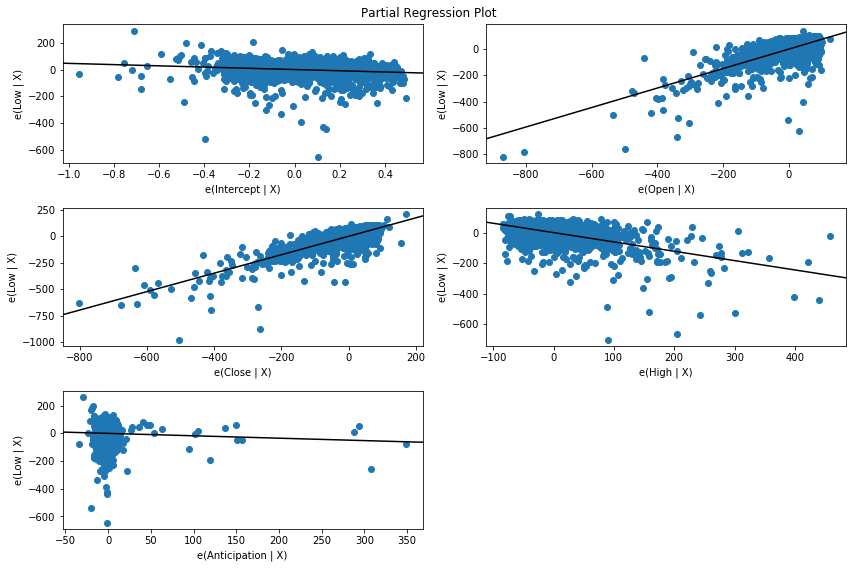

In [12]:
########################################################################################################
# MODELING 4 TODAY #####################################################################################
# Prepare formula to predict closing of stock data for today

# Get the highest sentiment and most significant feature against 'Close' for today
highest_sentiment1_today, significant_value1_today = identify_sig_feature_4_today("Close", "False")

# Update our 'Close' formula with the most significant feature based on today's data
formula = ('Close ~ Open + High + Low + ' + np.unicode(highest_sentiment1_today))

# Update our training data for 'Close'
dta = train_data[['Close', 'Open', 'High', 'Low', 'Anger', 'Anticipation',
                  'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                  'Trust', 'Negative', 'Positive', 'Sentiment_Proportion']].copy()

# Get best regularized fit paramters based on most significant sentiment feature for 'Close' and today.
alpha_val, weight_val = get_fit_regression_params(highest_sentiment1_today, "Close", significant_value1_today)

# Create a Ordinary Least Squares regression model
lm1_today = smf.ols(formula=formula, data=dta).fit_regularized(alpha=alpha_val, L1_wt=weight_val)

# Print regression graph
fig1 = plt.figure(figsize=(12, 8))
fig1 = sm.graphics.plot_partregress_grid(lm1_today, fig=fig1)
#fig1
#fig1.savefig('Today_Close_Regression.png')

# Predicts closing value based on train data and model above
today_close_prediction = lm1_today.predict(today_record)

########################################################################################################################
# Prepare formula to predict High of stock data for today

# Get the highest sentiment and most significant feature against 'High' for today 
highest_sentiment2_today, significant_value2_today = identify_sig_feature_4_today("High", "False")

# Update our 'High' formula with the most significant feature based on today's data
formula = ('High ~ Open + Close + Low + ' + np.unicode(highest_sentiment2_today))

# Update our training data for 'High'
dta = train_data[['High', 'Open', 'Close', 'Low', 'Anger', 'Anticipation',
                  'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                  'Trust', 'Negative', 'Positive', 'Sentiment_Proportion']].copy()

# Get best regularized fit paramters based on most significant sentiment feature for 'High' and today.
alpha_val, weight_val = get_fit_regression_params(highest_sentiment2_today, "High", significant_value2_today)

# Create a Ordinary Least Squares regression model
lm2_today = smf.ols(formula=formula, data=dta).fit_regularized(alpha=alpha_val, L1_wt=weight_val)

# Print regression graph
fig2 = plt.figure(figsize=(12, 8))
fig2 = sm.graphics.plot_partregress_grid(lm2_today, fig=fig2)
#fig2
#fig2.savefig('Today_High_Regression.png')  # Show Partial regression plot of model

# Predicts high value based on train data and model above
today_high_prediction = lm2_today.predict(today_record)

########################################################################################################################
# Prepare formula to predict Low of stock data for today

# Get the highest sentiment and most significant feature against 'Low' for today 
highest_sentiment3_today, significant_value3_today = identify_sig_feature_4_today("Low", "False")

# Update our 'Low' formula with the most significant feature based on today's data
formula = ('Low ~ Open + Close + High + ' + np.unicode(highest_sentiment3_today))

# Update our training data for 'Low'
dta = train_data[['Low', 'Open', 'Close', 'High', 'Anger', 'Anticipation',
                  'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                  'Trust', 'Negative', 'Positive', 'Sentiment_Proportion']].copy()

# Get best regularized fit paramters based on most significant sentiment feature for 'Low' and today.
alpha_val, weight_val = get_fit_regression_params(highest_sentiment3_today, "Low", significant_value3_today)

# Create a Ordinary Least Squares regression model
lm3_today = smf.ols(formula=formula, data=dta).fit_regularized(alpha=alpha_val, L1_wt=weight_val)

# Print regression graph
fig3 = plt.figure(figsize=(12, 8))
fig3 = sm.graphics.plot_partregress_grid(lm3_today, fig=fig3)
#fig3
#fig3.savefig('Today_Low_Regression.png')  # Show Partial regression plot of model

# Predicts Low value based on train data and model above
today_low_prediction = lm3_today.predict(today_record)

After our predicting, now let's print results and compare with actuals...

In [13]:
print("The Close value for today's stock is predicted to be: " + str(today_close_prediction.iloc[0]))
print("The High value for today's stock is predicted to be: " + str(today_high_prediction.iloc[0]))
print("The Low value for today's stock is predicted to be: " + str(today_low_prediction.iloc[0]))
print("")
print("ACTUAL Close value for today: " + str(today_record['Close'].iloc[0]))
print("ACTUAL High value for today: " + str(today_record['High'].iloc[0]))
print("ACTUAL Low value for today: " + str(today_record['Low'].iloc[0]))

The Close value for today's stock is predicted to be: 25399.336863
The High value for today's stock is predicted to be: 25662.8429093
The Low value for today's stock is predicted to be: 25142.5851497

ACTUAL Close value for today: 25017.439453
ACTUAL High value for today: 25392.609375
ACTUAL Low value for today: 24900.980469


As we can see our results are pretty good. Let's re-use this methodology to actually try to predict for tomorrow's Closing, High, and Low values of the stock. This means we will include today's most recent actual stock data in our train dataset for our model (which we already separated out in Section 1 above).

The Close accuracy of the random forest for tomorrow sentiment is: 0.184934918143
The High accuracy of the random forest for tomorrow sentiment is: 0.183563898812
The Low accuracy of the random forest for tomorrow sentiment is: 0.181730060363


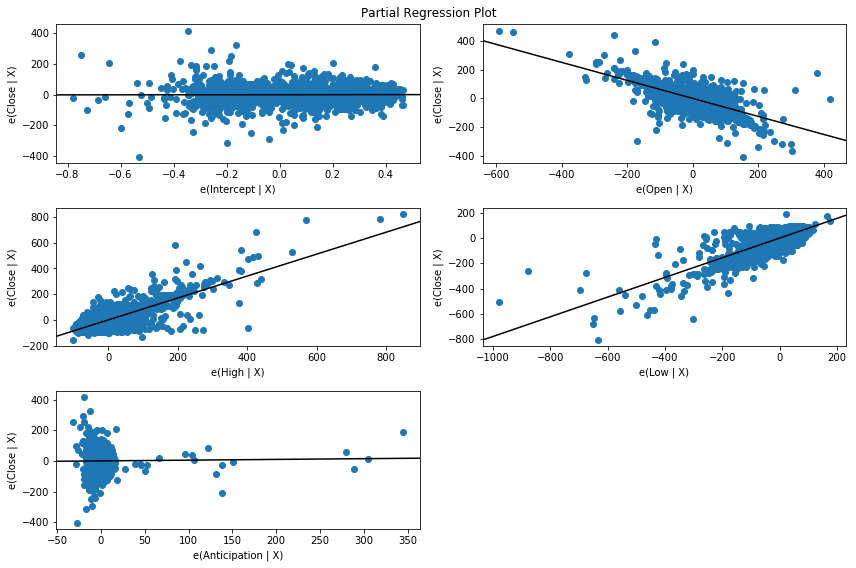

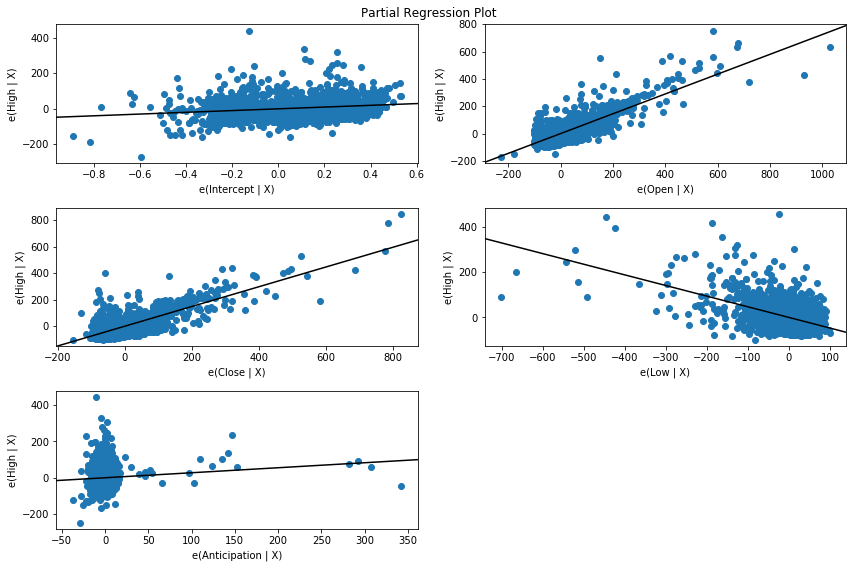

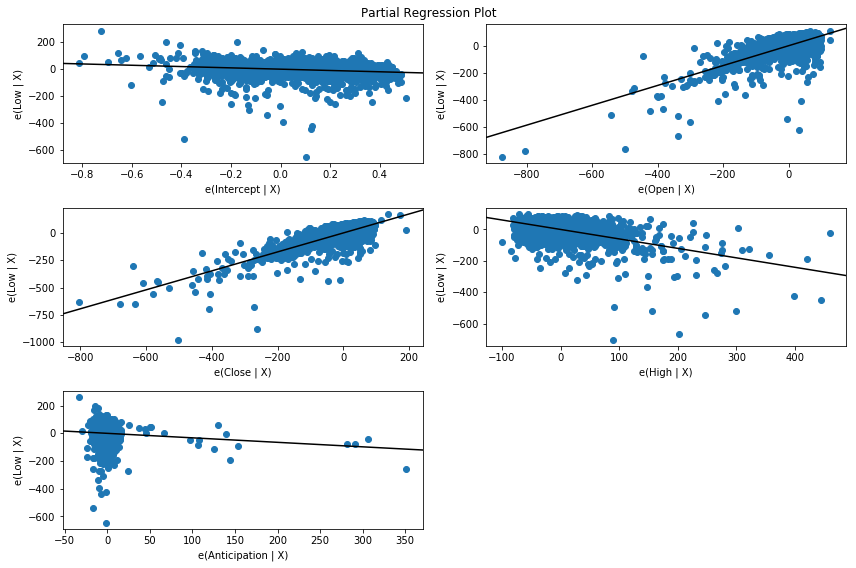

In [14]:
########################################################################################################
# MODELING 4 NEXT DAY###################################################################################

# Get the highest sentiment and most significant feature against 'Close' for tomorrow 
highest_sentiment1_tom, significant_value1_tom = identify_sig_feature_4_tomorrow("Close", "False")

# Update our 'Close' formula with the most significant feature based on tomorrow
formula = ('Close ~ Open + High + Low + ' + np.unicode(highest_sentiment1_tom))

# Update our training data for 'Close'
dta = train_data_tomorrow[['Close', 'Open', 'High', 'Low', 'Anger', 'Anticipation',
                           'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                           'Trust', 'Negative', 'Positive', 'Sentiment_Proportion']].copy()

# Get best regularized fit paramters based on most significant sentiment feature for 'Close' and tomorrow.
alpha_val, weight_val = get_fit_regression_params(highest_sentiment1_tom, "Close", significant_value1_tom)

# Create a Ordinary Least Squares regression model
lm1_tom = smf.ols(formula=formula, data=dta).fit_regularized(alpha=alpha_val, L1_wt=weight_val)

# Print regression graph
fig4 = plt.figure(figsize=(12, 8))
fig4 = sm.graphics.plot_partregress_grid(lm1_tom, fig=fig4)
#fig4
#fig4.savefig('Tomorrow_Close_Regression.png')  # Show Partial regression plot of model

# Predicts closing value based on train data and model above
close_prediction_tom = lm1_tom.predict(tomorrow_record)

########################################################################################################################
# Prepare formula to predict High of stock data for tomorrow

# Get the highest sentiment and most significant feature against 'High' for tomorrow 
highest_sentiment2_tom, significant_value2_tom = identify_sig_feature_4_tomorrow("High", "False")

# Update our 'High' formula with the most significant feature based on tomorrow
formula = ('High ~ Open + Close + Low + ' + np.unicode(highest_sentiment2_tom))

# Update our training data for 'High'
dta = train_data_tomorrow[['High', 'Open', 'Close', 'Low', 'Anger', 'Anticipation',
                           'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                           'Trust', 'Negative', 'Positive', 'Sentiment_Proportion']].copy()

# Get best regularized fit paramters based on most significant sentiment feature for 'High' and tomorrow.
alpha_val, weight_val = get_fit_regression_params(highest_sentiment2_tom, "High", significant_value2_tom)

# Create a Ordinary Least Squares regression model
lm2_tom = smf.ols(formula=formula, data=dta).fit_regularized(alpha=alpha_val, L1_wt=weight_val)

# Print regression graph
fig5 = plt.figure(figsize=(12, 8))
fig5 = sm.graphics.plot_partregress_grid(lm2_tom, fig=fig5)
#fig5
#fig5.savefig('Tomorrow_High_Regression.png')  # Show Partial regression plot of model

# Predicts high value based on train data and model above
high_prediction_tom = lm2_tom.predict(tomorrow_record)

########################################################################################################################
# Prepare formula to predict Low of stock data for tomorrow

# Prepare formula to predict Low of stock data for today
highest_sentiment3_tom, significant_value3_tom = identify_sig_feature_4_tomorrow("Low", "False")

# Update our 'Low' formula with the most significant feature based on tomorrow
formula = ('Low ~ Open + Close + High + ' + np.unicode(highest_sentiment3_tom))

# Update our training data for 'Low'
dta = train_data_tomorrow[['Low', 'Open', 'Close', 'High', 'Anger', 'Anticipation',
                           'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise',
                           'Trust', 'Negative', 'Positive', 'Sentiment_Proportion']].copy()

# Update our training data for 'Low'
alpha_val, weight_val = get_fit_regression_params(highest_sentiment3_tom, "Low", significant_value3_tom)

# Create a Ordinary Least Squares regression model
lm3_tom = smf.ols(formula=formula, data=dta).fit_regularized(alpha=alpha_val, L1_wt=weight_val)

# Print regression graph
fig6 = plt.figure(figsize=(12, 8))
fig6 = sm.graphics.plot_partregress_grid(lm3_tom, fig=fig6)
#fig6
#fig6.savefig('Tomorrow_Low_Regression.png')  # Show Partial regression plot of model

# Predicts Low value based on train data and model above
low_prediction_tom = lm3_tom.predict(tomorrow_record)

After our predicting, now let's print results. Unforuntately, we will not be able to possibly validate our predictions until the next buisness day closes of our stock.

In [15]:
print("The Close value for tomorrow's stock is estimated to be: " + str(close_prediction_tom.iloc[0]))
print("The High value for tomorrow's stock is estimated to be: " + str(high_prediction_tom.iloc[0]))
print("The Low value for tomorrow's stock is estimated to be: " + str(low_prediction_tom.iloc[0]))
print("")

# Should We Buy or Sell? :)

if float(today_close_prediction.iloc[0]) < float(close_prediction_tom.iloc[0]):
    print("Based on our algorithm, the Closing value for the stock tomorrow will: Increase")
else:
    print("Based on our algorithm, the Closing value for the stock tomorrow will: Decrease")

if float(today_high_prediction.iloc[0]) < float(high_prediction_tom.iloc[0]):
    print("Based on our algorithm, the High value for the stock tomorrow will: Increase")
else:
    print("Based on our algorithm, the High value for the stock tomorrow will: Decrease")

if float(today_low_prediction.iloc[0]) < float(low_prediction_tom.iloc[0]):
    print("Based on our algorithm, the Low value for the stock tomorrow will: Increase")
else:
    print("Based on our algorithm, the Low value for the stock tomorrow will: Decrease")

The Close value for tomorrow's stock is estimated to be: 25402.5497949
The High value for tomorrow's stock is estimated to be: 25551.6996697
The Low value for tomorrow's stock is estimated to be: 25227.3291538

Based on our algorithm, the Closing value for the stock tomorrow will: Increase
Based on our algorithm, the High value for the stock tomorrow will: Decrease
Based on our algorithm, the Low value for the stock tomorrow will: Increase
